In [1]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################

import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [15, 10]
import json
import pandas as pd
import glob
import math
import ast
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('../logs/cleps-logs/small_test_data/*' )

#print(LOGFILES)
print(len(LOGFILES),"logs")

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'solid',
    'SelfHealing':    'solid',
    'Naive'      :    'solid',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :     'orange',
     
   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

80 logs


In [44]:
#==================================================== GATHER DATA =============================================
data = {}
configs    = set()
for file in LOGFILES:
    FILENAME = file

    time       = []
    pdrs       = []
    avg_pdr    = []
    num_relays = []
    num_cells  = []
    run_data   = {}
    pdr_data   = []
    config     = None


    # gather
    with open(FILENAME,'r') as f:
        for line in f.readlines():
            jsonline = json.loads(line)
            if jsonline["type"] == "sim configuration":
                config = jsonline

                configs.add(str(config))
                if str(config) not in data.keys():
                    data[str(config)] = [] 
            if jsonline["type"]!='timeseries_kpi':
                continue

            # store
            time       += [jsonline["time"]]
            pdrs       += [[e[2] for e in jsonline["pdrProfile"]]]
            pdr_data   += [jsonline["pdrProfile"]]
            num_relays += [len([e[3] for e in jsonline["pdrProfile"] if e[3]])]
            num_cells  += [jsonline["numCells"]]
            
        run_data['time']            = time
        run_data['pdrs']            = pdrs
        run_data['num_relays']      = num_relays
        run_data['mappingProfile']  = num_cells
        run_data['pdr_data']        = pdr_data
        run_data['config']          = config
        data[str(config)] += [run_data]


c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


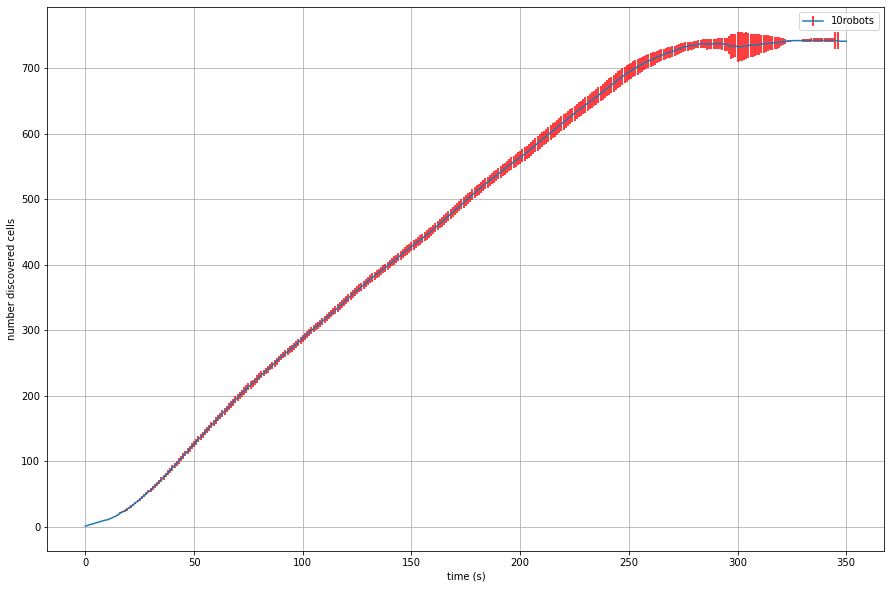

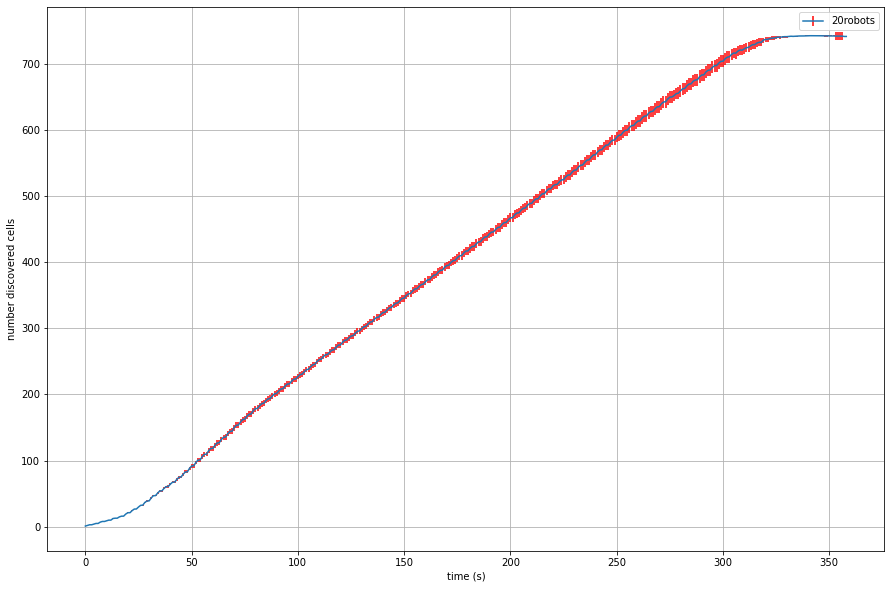

In [3]:
#===================================== MAPPING PROFILE=================================
plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
mapping_profiles = {}
plot_data = {}
for config,runs in data.items():
    mapping_profiles[str(config)] = [run['mappingProfile'] for run in runs]


for config,profiles in mapping_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
        (m,h) = mean_confidence_interval(l)
        ms += [m]
        hs += [h]
        plot_data[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }

        
for config in configs:
    settings = ast.literal_eval(config)
    numDotBots = settings['numDotBots']
    (fig,ax) = plt.subplots()
    lines    = {}
    for c,profile in plot_data.items():
        if c != config:
            continue
        x             = range(len(profile['mean']))
        y             = profile['mean']
        yerr          = profile['confidence_interval']
        ax.errorbar(x=x,y=y,yerr=yerr, ecolor='r', label = str(numDotBots)+"robots" )

    ax.grid(True, zorder=5)
    alllines = lines
    plt.xlabel('time (s)')
    plt.ylabel('number discovered cells')
    plt.legend()
    plt.show()

        
    
        
        
    

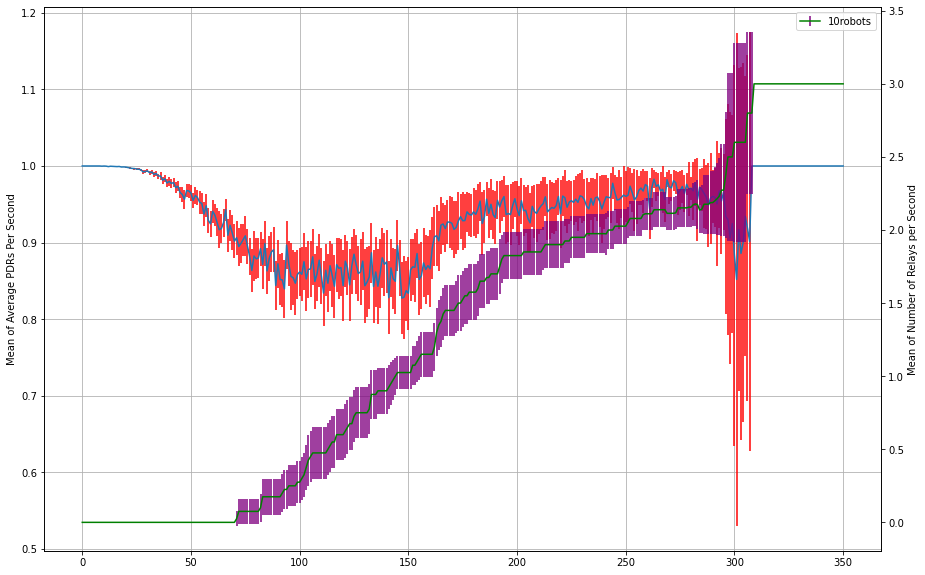

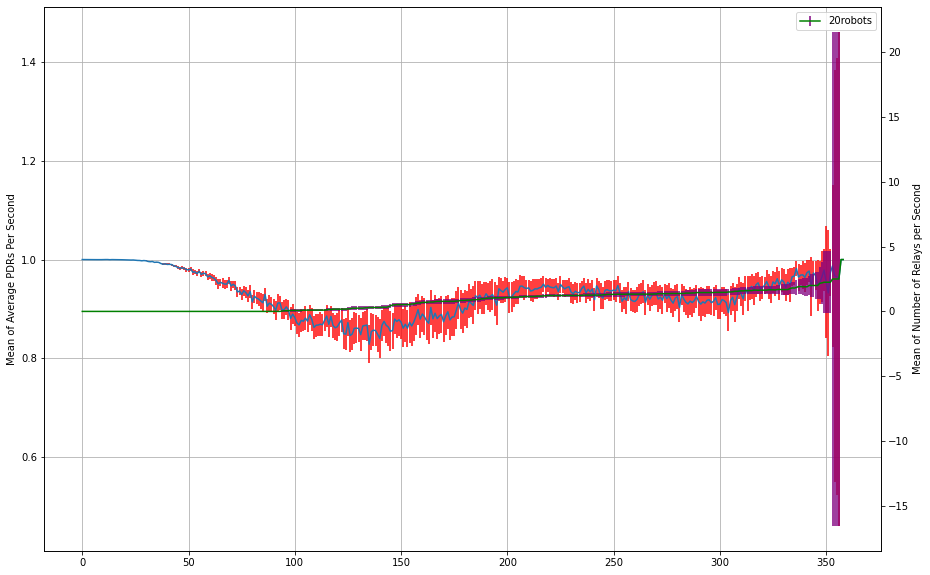

In [10]:
#================================== AVERAGE PDR AND RELAY PLACEMENT ==================================================
# The aim of this plot is to see how the placement of relays is affecting/improving PDR
# since we know pister hack is based on experimental randomness, in theory mapping should still complete without relays but much slower.
# Would be good to have a plot for a no relay config to compare against [baseline]


plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
avg_pdr_profiles = {}
relay_profiles = {}
plot_data_pdr = {}
plot_data_relay = {}



for config,runs in data.items():
    avg_pdr_profiles[str(config)] = []
    pdr_profiles  = [run['pdrs'] for run in runs]
    for profile in pdr_profiles:
        avg_pdr_profiles[str(config)] += [[(float(sum(p))/len(p)) for p in profile ]]
    relay_profiles[config] = [run['num_relays'] for run in runs]

for config,profiles in relay_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
        (m,h) = mean_confidence_interval(l)
        if l:
            ms += [m]
            hs += [h]
        plot_data_relay[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }



for config,profiles in avg_pdr_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
        (m,h) = mean_confidence_interval(l)
        ms += [m]
        hs += [h]
        plot_data_pdr[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }

    
for config in configs:
    settings = ast.literal_eval(config)
    numDotBots = settings['numDotBots']
    (fig,ax) = plt.subplots()
    lines    = {}
    lines2 = {}
    for c,profile in plot_data_pdr.items():
        if c != config:
            continue
        x             = range(len(profile['mean']))
        y             = profile['mean']
        yerr          = profile['confidence_interval']
        lines[c]      = ax.errorbar(x=x,y=y,yerr=yerr, ecolor = 'r',label = str(numDotBots)+"robots")
        
    for c,profile in plot_data_relay.items():
        if c != config:
            continue
        x2             = range(len(profile['mean']))
        y2             = profile['mean']
        yerr2          = profile['confidence_interval']
        ax2            = ax.twinx()
        ax2.errorbar(x=x2,y=y2,yerr=yerr2, color='g',ecolor= 'purple' ,label = str(numDotBots)+"robots")

    
    ax.grid(True, zorder=5)
    ax2.set_ylabel('Mean of Number of Relays per Second')
    plt.xlabel('Time (s)')
    ax.set_ylabel('Mean of Average PDRs Per Second')

    plt.legend()
    alllines = lines
    plt.show()

No handles with labels found to put in legend.


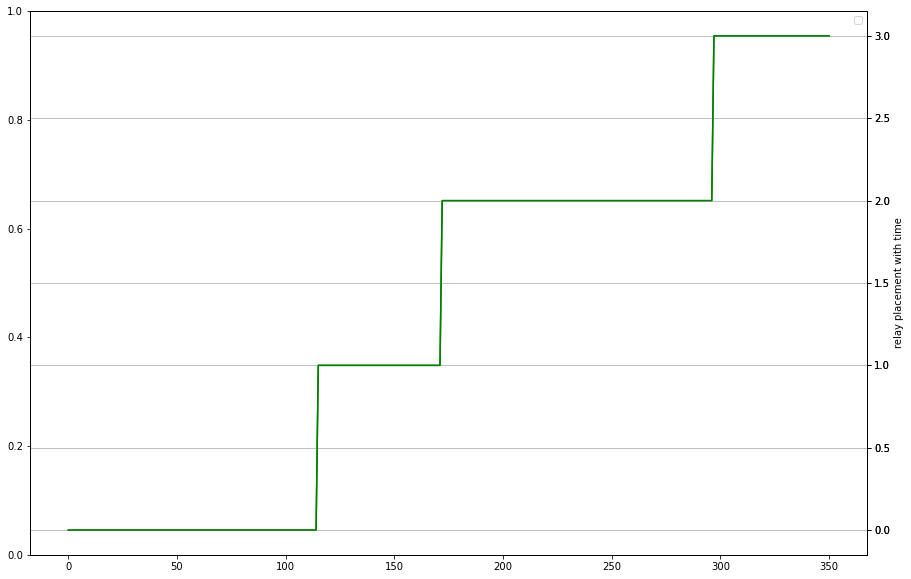

No handles with labels found to put in legend.


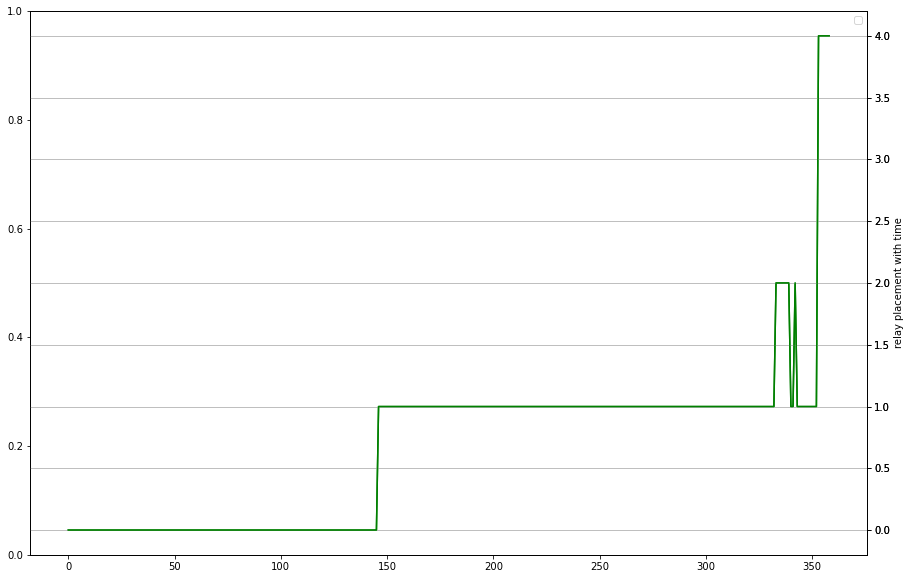

In [5]:
#================================== NUMER OF RELAYS PER SECOND ==================================================

import math
import statistics
from statistics import mode

plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
avg_pdr_profiles = {}
relay_profiles = {}
plot_data_pdr = {}
plot_data_relay = {}

for config,runs in data.items():
    relay_profiles[config] = [run['num_relays'] for run in runs]

for config,profiles in relay_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
        (m,h) = mean_confidence_interval(l)
        if l:
            ms += [mode(l)]
            hs += [h]
        plot_data_relay[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }
    
for config in configs:
    (fig,ax) = plt.subplots()
    lines2 = {}
    for c,profile in plot_data_relay.items():
        if c != config:
            continue
        x2             = range(len(profile['mean']))
        y2             = profile['mean']
        yerr2          = profile['confidence_interval']
        ax2            = ax.twinx()
        ax2.errorbar(x=x2,y=y2,yerr=0, color='g',ecolor='r')

    for c,profile in plot_data_relay.items():
        if c != config:
            continue
        x2             = range(len(profile['mean']))
        y2             = profile['mean']
        yerr2          = profile['confidence_interval']
        ax2            = ax.twinx()
        ax2.errorbar(x=x2,y=y2,yerr=0, color='g',ecolor='r')
  
    ax2.grid(True, zorder=5)
    plt.xlabel('Time (s)')
    plt.ylabel('relay placement with time')

    plt.legend()
    alllines = lines
    plt.show()

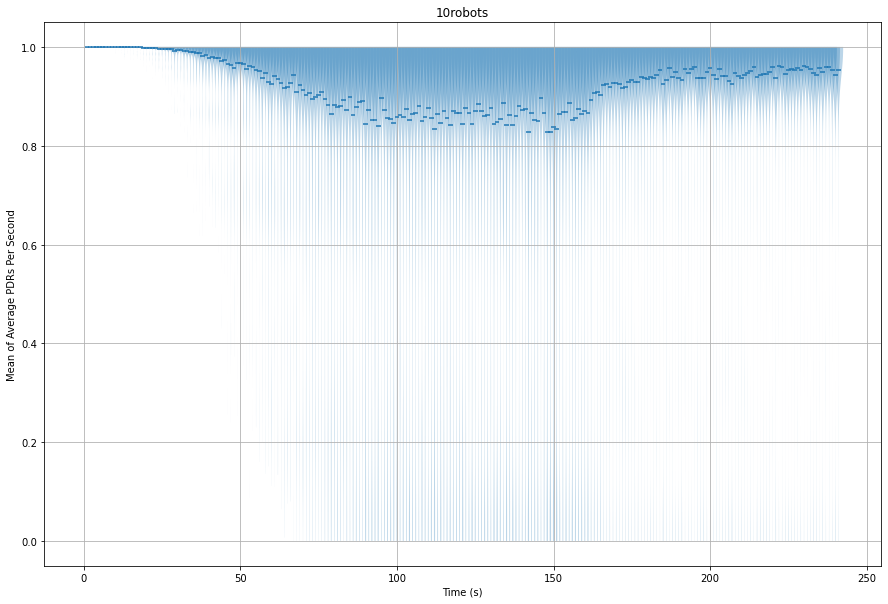

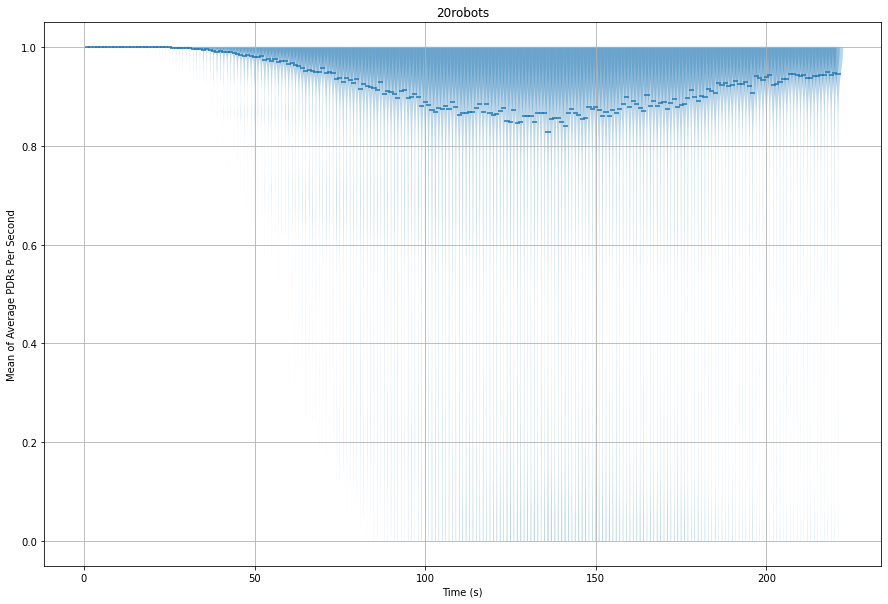

In [6]:
#================================== PDR violin plots ==================================================
#-----------will group every 100 seconds together

plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
all_pdr_profiles = {}
relay_profiles = {}
plot_data_pdr = {}
plot_data_violin = {}
collections ={}

#---------------- PDR data aggregation      

for config,runs in data.items():
    
    all_pdr_profiles[str(config)] = [run['pdrs'] for run in runs]
    collections[config] = []
    
for config,profiles in all_pdr_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    for i in range(maxlen):
        l = []
        try:
            profile_per_sec = [p[i] for p in profiles]
            for p in profile_per_sec:
                for pdr in p:
                    l.append(pdr)

        except IndexError:
            pass

        if l:
            collections[config] += [l]

            
#----------------relay aggrigation
for config,profiles in relay_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
        (m,h) = mean_confidence_interval(l)
        if l:
            ms += [m]
            hs += [h]
        plot_data_relay[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }
#-------------------plots
for config in configs:
    settings = ast.literal_eval(config)
    numDotBots = settings['numDotBots']
    (fig,ax) = plt.subplots()
    lines    = {}
    for c,profile in collections.items():
        if c != str(config):
            continue
        x             = range(len(profile))
        y             = profile
        lines[c]      = ax.violinplot(y, vert=True, widths =3, showmeans=True, showextrema=False)


        
        ax.grid(True, zorder=5)
        ax2.set_ylabel('Mean of Number of Relays per Second')
        plt.xlabel('Time (s)')
        ax.set_ylabel('Mean of Average PDRs Per Second')

        plt.title(str(numDotBots)+"robots")
        alllines = lines
        plt.show()
    

[[6, [5.0, 3.5], 0.9848654776428403, False], [1, [5.0, 0.5], 1.0, False], [5, [5.0, 0.0], 1.0, False], [3, [2.5, 0.5], 1.0, False], [7, [3.0, 5.5], 1.0, False], [0, [1.0, 5.5], 1.0, False], [2, [3.0, 5.5], 1.0, False], [4, [5.0, 4.0], 1.0, False], [9, [2.5, 6.0], 1.0, False], [8, [5.5, 5.5], 1.0, False]]


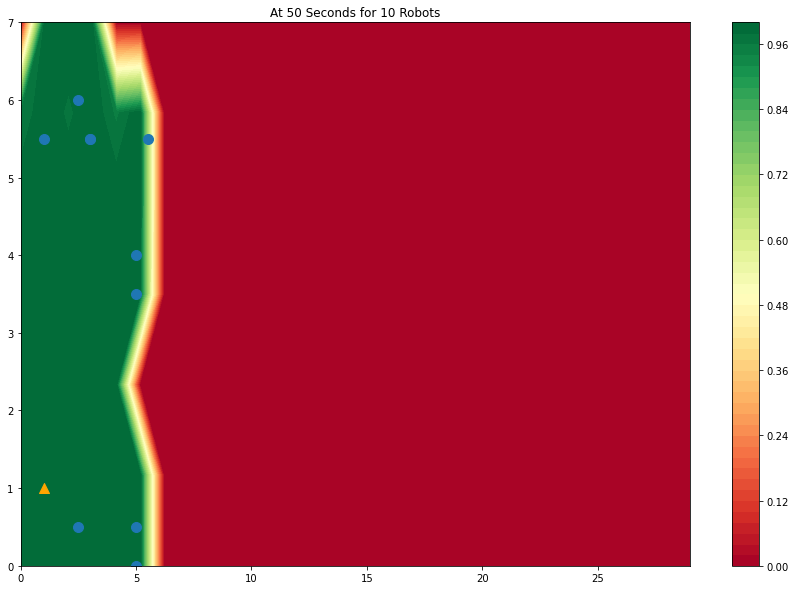

[[8, [14.0, 5.5], 0.0, False], [6, [15.0, 4.0], 0.6925710771266183, False], [4, [15.0, 4.5], 0.9912233230601329, False], [1, [15.5, 1.0], 0.0, False], [0, [15.5, 2.0], 0.837611358302479, False], [3, [15.5, 2.5], 1.0, False], [9, [15.5, 2.5], 0.16346862467687903, False], [7, [15.5, 4.5], 0.0, False], [5, [15.5, 1.5], 0.9844758099484429, False], [2, [15.5, 4.5], 1.0, False]]


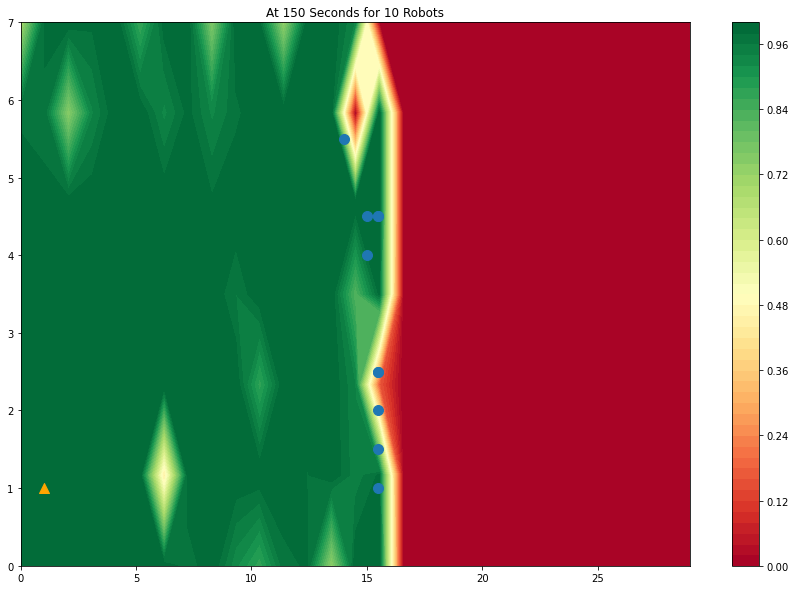

[[0, [25.5, 4.5], 1.0, False], [4, [25.5, 4.5], 1.0, False], [6, [16.5, 4.0], 0.9925, True], [9, [26.5, 3.5], 0.9979, False], [1, [25.5, 4.5], 1.0, False], [2, [18.0, 2.0], 1.0, True], [7, [25.0, 4.5], 0.9998, False], [8, [26.5, 3.5], 0.9922, False], [3, [26.5, 3.0], 1.0, False], [5, [25.5, 4.5], 1.0, False]]


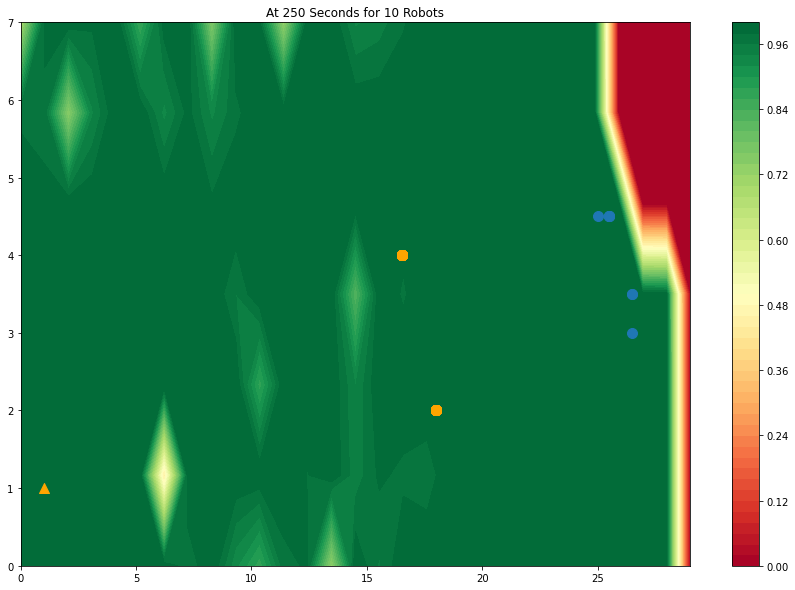

[[14, [4.5, 2.0], 0.9806549366402763, False], [0, [4.5, 2.5], 1.0, False], [3, [4.5, 0.5], 1.0, False], [17, [4.0, 3.5], 1.0, False], [12, [4.5, 0.5], 1.0, False], [9, [5.5, 0.5], 1.0, False], [19, [4.0, 3.5], 1.0, False], [1, [2.0, 4.0], 1.0, False], [16, [5.0, 1.0], 0.9398267453730147, False], [10, [4.0, 2.0], 0.9849705484181416, False], [18, [4.0, 3.5], 0.9290181362152583, False], [15, [4.0, 3.5], 0.7785000974064847, False], [6, [5.0, 2.0], 0.723749621243005, False], [7, [4.5, 2.5], 1.0, False], [8, [5.0, 2.0], 0.9740894514203305, False], [11, [4.0, 2.5], 1.0, False], [2, [1.5, 4.0], 0.9846632304573952, False], [5, [1.0, 4.0], 1.0, False], [13, [4.0, 3.5], 0.949247442744219, False], [4, [5.5, 0.5], 1.0, False]]


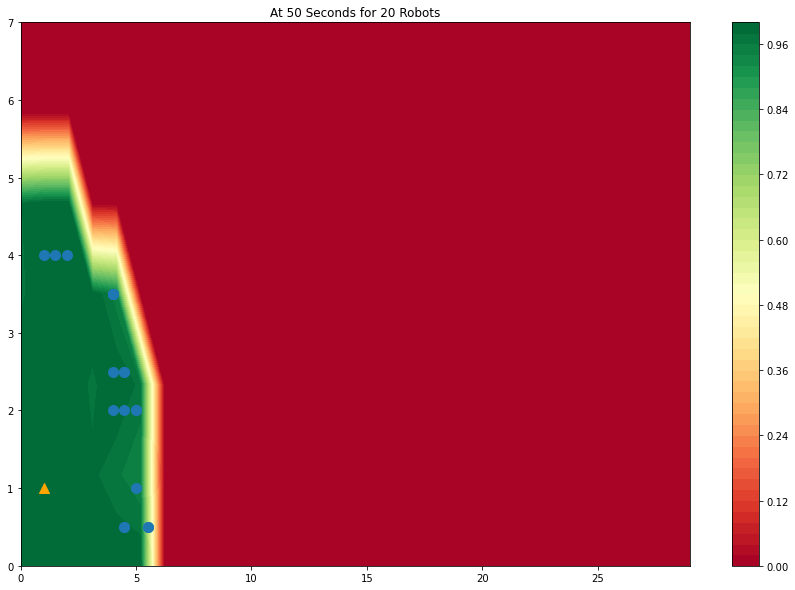

[[12, [13.0, 0.5], 1.0, False], [17, [12.5, 5.5], 1.0, False], [2, [13.0, 4.5], 1.0, False], [18, [11.5, 5.5], 0.8666, False], [0, [14.0, 0.5], 1.0, False], [13, [12.5, 3.5], 0.9741, False], [8, [13.5, 0.5], 1.0, False], [4, [14.0, 1.0], 1.0, False], [1, [13.0, 4.5], 1.0, False], [11, [13.5, 1.0], 1.0, False], [7, [12.5, 0.5], 0.0, True], [14, [12.5, 3.5], 1.0, False], [6, [14.0, 0.5], 1.0, False], [15, [12.0, 6.0], 1.0, False], [19, [13.0, 4.0], 1.0, False], [3, [13.0, 4.5], 1.0, False], [10, [12.5, 5.0], 1.0, False], [5, [14.0, 2.0], 1.0, False], [16, [13.5, 1.0], 1.0, False], [9, [14.0, 0.5], 1.0, False]]


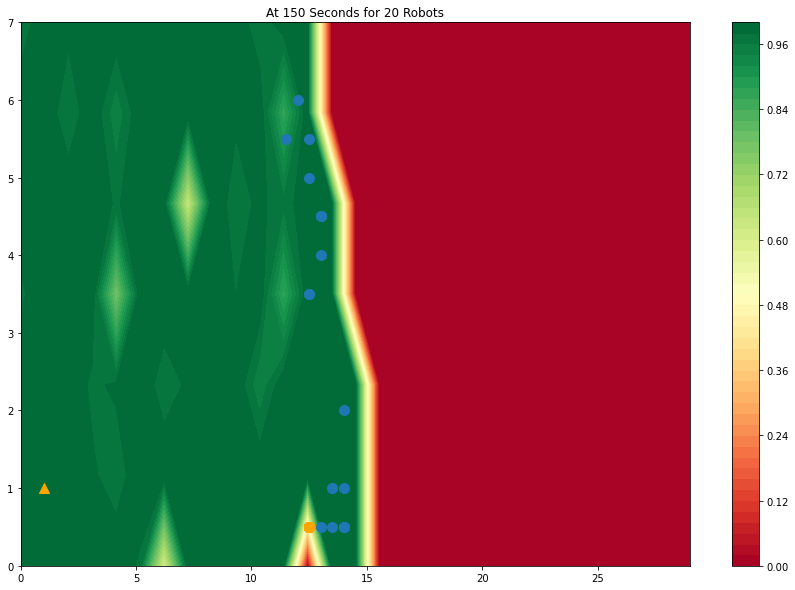

[[6, [23.5, 1.5], 0.6533, False], [7, [12.5, 0.5], 0.9368, True], [3, [23.0, 1.5], 0.9742999999999999, False], [4, [22.5, 4.5], 1.0, False], [13, [22.0, 3.5], 0.9896, False], [10, [22.5, 4.0], 1.0, False], [5, [23.5, 1.5], 0.9257, False], [19, [21.0, 5.5], 1.0, False], [18, [22.5, 2.0], 1.0, False], [15, [22.0, 6.0], 1.0, False], [9, [22.5, 5.0], 0.9745, False], [2, [22.5, 3.5], 1.0, False], [16, [22.0, 0.5], 0.9995, False], [0, [23.5, 1.0], 0.7816, False], [8, [22.5, 4.5], 0.9583, False], [12, [23.0, 1.5], 1.0, False], [17, [23.0, 1.5], 0.9854, False], [1, [22.5, 3.5], 1.0, False], [11, [23.0, 1.5], 1.0, False], [14, [23.0, 2.5], 1.0, False]]


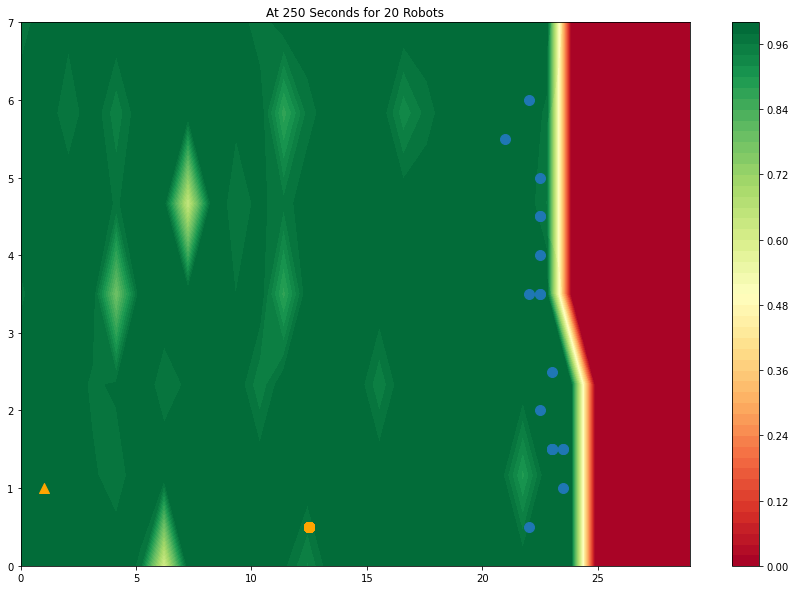

In [269]:
####################################### COUNTOR HEATMAPS #######################################################33

plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
heatmap_profiles = {}
heatmap_data     = {}


for config,runs in data.items():
    settings = ast.literal_eval(config)
    numDotBots = settings['numDotBots']
    for run in runs: 

        heatmap_data = run['pdr_data']
        maxx  = int(max([max([e[1][0] for e in i]) for i in heatmap_data]))
        maxy  = int(max([max([e[1][1] for e in i]) for i in heatmap_data]))
        X     = np.linspace(0, int(maxx+1), int(maxx+1))
        Y     = np.linspace(0, int(maxy+1), int(maxy+1))
        X, Y  = np.meshgrid(X,Y)
        Z     = np.zeros(shape=(int(maxy+1),int(maxx+1)))
        rx    = []
        ry    = []

        for idx,i in enumerate(heatmap_data):
            for e in i:
                xs = []
                ys = []
                for e in i:
                    ex, ey = e[1][0], e[1][1]
                    Z[int(ey)][int(ex)] = e[2]
                    if e[3] == True:
                        rx += [ex]
                        ry += [ey]
                    else:
                        xs += [ex]
                        ys += [ey]
            
            if idx == 50 or idx == 150 or idx == 250:
                print(i)
                CS1 = plt.contourf(X,Y,Z,60, cmap='RdYlGn')

                plt.colorbar()
                plt.scatter(1,1, color='orange', marker="^", s=100)
                plt.scatter(rx,ry, color='orange', s=100)
                plt.scatter(xs,ys, s=100)
                plt.title("At "+str(idx)+" Seconds"+" for "+str(numDotBots)+" Robots")
                plt.show()  
        break

